# Introduction

Hello, I'm **Wesley**, nice to meet you! 👋

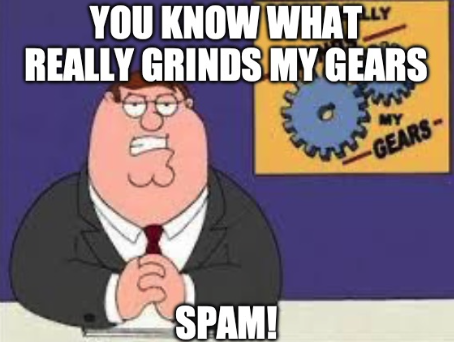

Let's make a sms spam classifier!
Here we'll be using [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) on [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) with a [Singaporean SMS Spam dataset](https://huggingface.co/datasets/sms_spam).

# Setup Python Libraries (Quietly 🤫)

In [1]:
%%bash
pip install numpy torch datasets transformers evaluate --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==2.1.0
evaluate==0.4.0
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl
torchdata==0.6.0
torchinfo==1.7.2
torchmetrics==0.11.4
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl
transformers==4.28.1


# Create SMS Spam Dataset for Training BERT

## Let's load the SMS Spam Dataset

In [2]:
from datasets import load_dataset

# we load the sms spam dataset from the huggingface hub [source: https://huggingface.co/datasets/sms_spam]

raw_dataset = load_dataset('sms_spam')
raw_dataset

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Dataset sms_spam downloaded and prepared to /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [3]:
# let's look at 5 examples of the sms spam data
# sms: The sms text message
# label: 1=SPAM and 0=HAM/NOT SPAM
for i in range(5):
    print(f"SMS[{i}]  : {raw_dataset['train']['sms'][i]}", end='')
    print(f"LABEL[{i}]: {'SPAM' if raw_dataset['train']['label'][i] else 'HAM'}\n")

SMS[0]  : Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
LABEL[0]: HAM

SMS[1]  : Ok lar... Joking wif u oni...
LABEL[1]: HAM

SMS[2]  : Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
LABEL[2]: SPAM

SMS[3]  : U dun say so early hor... U c already then say...
LABEL[3]: HAM

SMS[4]  : Nah I don't think he goes to usf, he lives around here though
LABEL[4]: HAM



## Let's create a train, validation, and test set 

In [4]:
# we first split train to 80% of total and test to 20% of total
train_test_dataset = raw_dataset['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 4459
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 1115
    })
})

In [5]:
# we then split the validation test to 10% of total and test set to 10% of total
val_test_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)
val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 557
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 558
    })
})

In [6]:
from datasets import DatasetDict

# we get a 80% train, 10% validation, 10% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'val': val_test_dataset['train'],
    'test': val_test_dataset['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 4459
    })
    val: Dataset({
        features: ['sms', 'label'],
        num_rows: 557
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 558
    })
})

# Setup Training (Fine-Tuning) on BERT

## We start by tokenizing our dataset

In [7]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [8]:
def tokenization(example):
    # we lower case the examples as the model is uncased 
    lowercased_example = list(map(str.lower, example['sms']))
    # we only truncate due to data collator's dynamic padding
    return tokenizer(lowercased_example, truncation=True)

# we tokenize the sms in batches and remove the original column
tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['sms'])
tokenized_dataset

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4459
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 557
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 558
    })
})

## We setup a data collator for dynamic padding

In [9]:
from transformers import DataCollatorWithPadding

# we setup a data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## We setup the training metrics (Accuracy, F1)

In [10]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

## We disable WandB Logging

In [11]:
import os
os.environ['WANDB_DISABLED'] = 'true'

## We setup the BERT model as a binary classifier

In [12]:
from transformers import AutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased'
num_labels = 2
id2label = {0:'HAM',1:'SPAM'}
label2id = {'HAM':0,'SPAM':1}

# source: https://huggingface.co/distilbert-base-uncased
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

## We setup Training Configurations 

In [13]:
from transformers import Trainer, TrainingArguments

# training configuration
# 1. seed: for reproducibility
# 2. output_dir: for outputing the model
# 3. num_train_epochs: we train 3 epochs
# 4. save_strategy: we save on every epoch to output_dir
# 5. evaluation_strategy: we evaluate on validation set on every epoch
# 6. load_best_model_at_end: we load the best model with the lowest validation loss
training_args = TrainingArguments(
    seed=42,
    output_dir='./results',
    num_train_epochs=3,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
)

# we setup the trainer with all our previous configurations
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Let's see how UnFine-Tuned BERT performs as a Baseline

In [14]:
trainer.evaluate(tokenized_dataset['test'])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7037670612335205,
 'eval_accuracy': 0.2885304659498208,
 'eval_f1': 0.047961630695443645,
 'eval_runtime': 2.1209,
 'eval_samples_per_second': 263.093,
 'eval_steps_per_second': 33.004}

Without fine-tuning BERT, our model currently has around **28% Accuracy (eval_accuracy)** and **4% F1 (eval_f1)**, which is quite bad. 😕

Let's make it better with transfer learning! 🦾

# Train (Fine-Tune) BERT

In [15]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.086000,0.045346,0.991023,0.967320
2,0.017700,0.063865,0.991023,0.966887
3,0.010800,0.049890,0.994614,0.980392


TrainOutput(global_step=1674, training_loss=0.03433031648433052, metrics={'train_runtime': 69.6785, 'train_samples_per_second': 191.982, 'train_steps_per_second': 24.025, 'total_flos': 188258941324320.0, 'train_loss': 0.03433031648433052, 'epoch': 3.0})

## Let's see how a Fine-Tuned BERT performs

In [16]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.09708648920059204,
 'eval_accuracy': 0.985663082437276,
 'eval_f1': 0.9428571428571428,
 'eval_runtime': 0.695,
 'eval_samples_per_second': 802.915,
 'eval_steps_per_second': 100.724,
 'epoch': 3.0}

Woah! We got a **98% Accuracy (eval_accuracy)** and **94% F1 (eval_f1)** in **1 minute**! 🤯

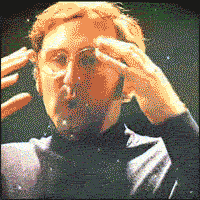

# Let's try out some examples!

In [17]:
import torch
from transformers import pipeline

# we setup the spam classifier as a text classification with our custom model and pretrained tokenizer
spam_classifier = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=torch.cuda.current_device())

In [18]:
# Let's try out some real-world spams!
# This is a spam message I got personally, please do not click it.

sms = """
+26.787$ burn out in 24 hours, Let it have drowned, http://bit.ly/7ayp
"""

spam_classifier(sms)

[{'label': 'SPAM', 'score': 0.9991658926010132}]

In [19]:
# Let's try out some real-word hams!
# This is a ham message I got personally.

sms = """
Hey want to cook something together tonight?
"""
spam_classifier(sms)

[{'label': 'HAM', 'score': 0.999749481678009}]